# Lab 9 Report:
## Final Project Codebase
### Project Title: Relationship Between Galaxy Spectra and Image
### Group Members: Madeline Legate and Julian Bermudez-Ortega

### **Overview of Project:**

---

1. **Prepare Data**

    i. Initial Dataset \\
    ii. SDSS API Call \\
    iii. Scaling + Portioning

2. **Define Model**
    
    i. Load Dataset \\
    ii. Encoder & Decoder \\

3. **Define Hyperparameters**
4. **Identify Tracked Values**
5. **Train Model**
6. **Visualize & Evaluate Model**
    
    i. Training Loss \\
    ii. Testing Accuracy \\
    iii. Evaluate Performance

### **Prepare Data**

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import Image
from PIL import Image
import io
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

#### Initial Dataset

In [ ]:
# Read CSV file containing spectra of stellar objects
data = pd.read_csv('star_classification.csv')

# Drop redundant/not useful columns pertaining to SDSS object IDs
data = data.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD','fiber_ID'], axis=1)
data = data.rename(columns={'class' : 'obj'})

In [ ]:
# Segment data based on class, note df.loc preserves index of original dataframe
galaxies = data.loc[data.obj=='GALAXY', ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']]
qsos = data.loc[data.obj=='QSO', ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']]
stars = data.loc[data.obj=='STAR', ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift']]

print(galaxies.shape, qsos.shape, stars.shape)

(59445, 8) (18961, 8) (21594, 8)


In [ ]:
# CHOOSE DATASET FOR TRAINING AND TESTING
input_spectra = galaxies.copy()
output_images = []

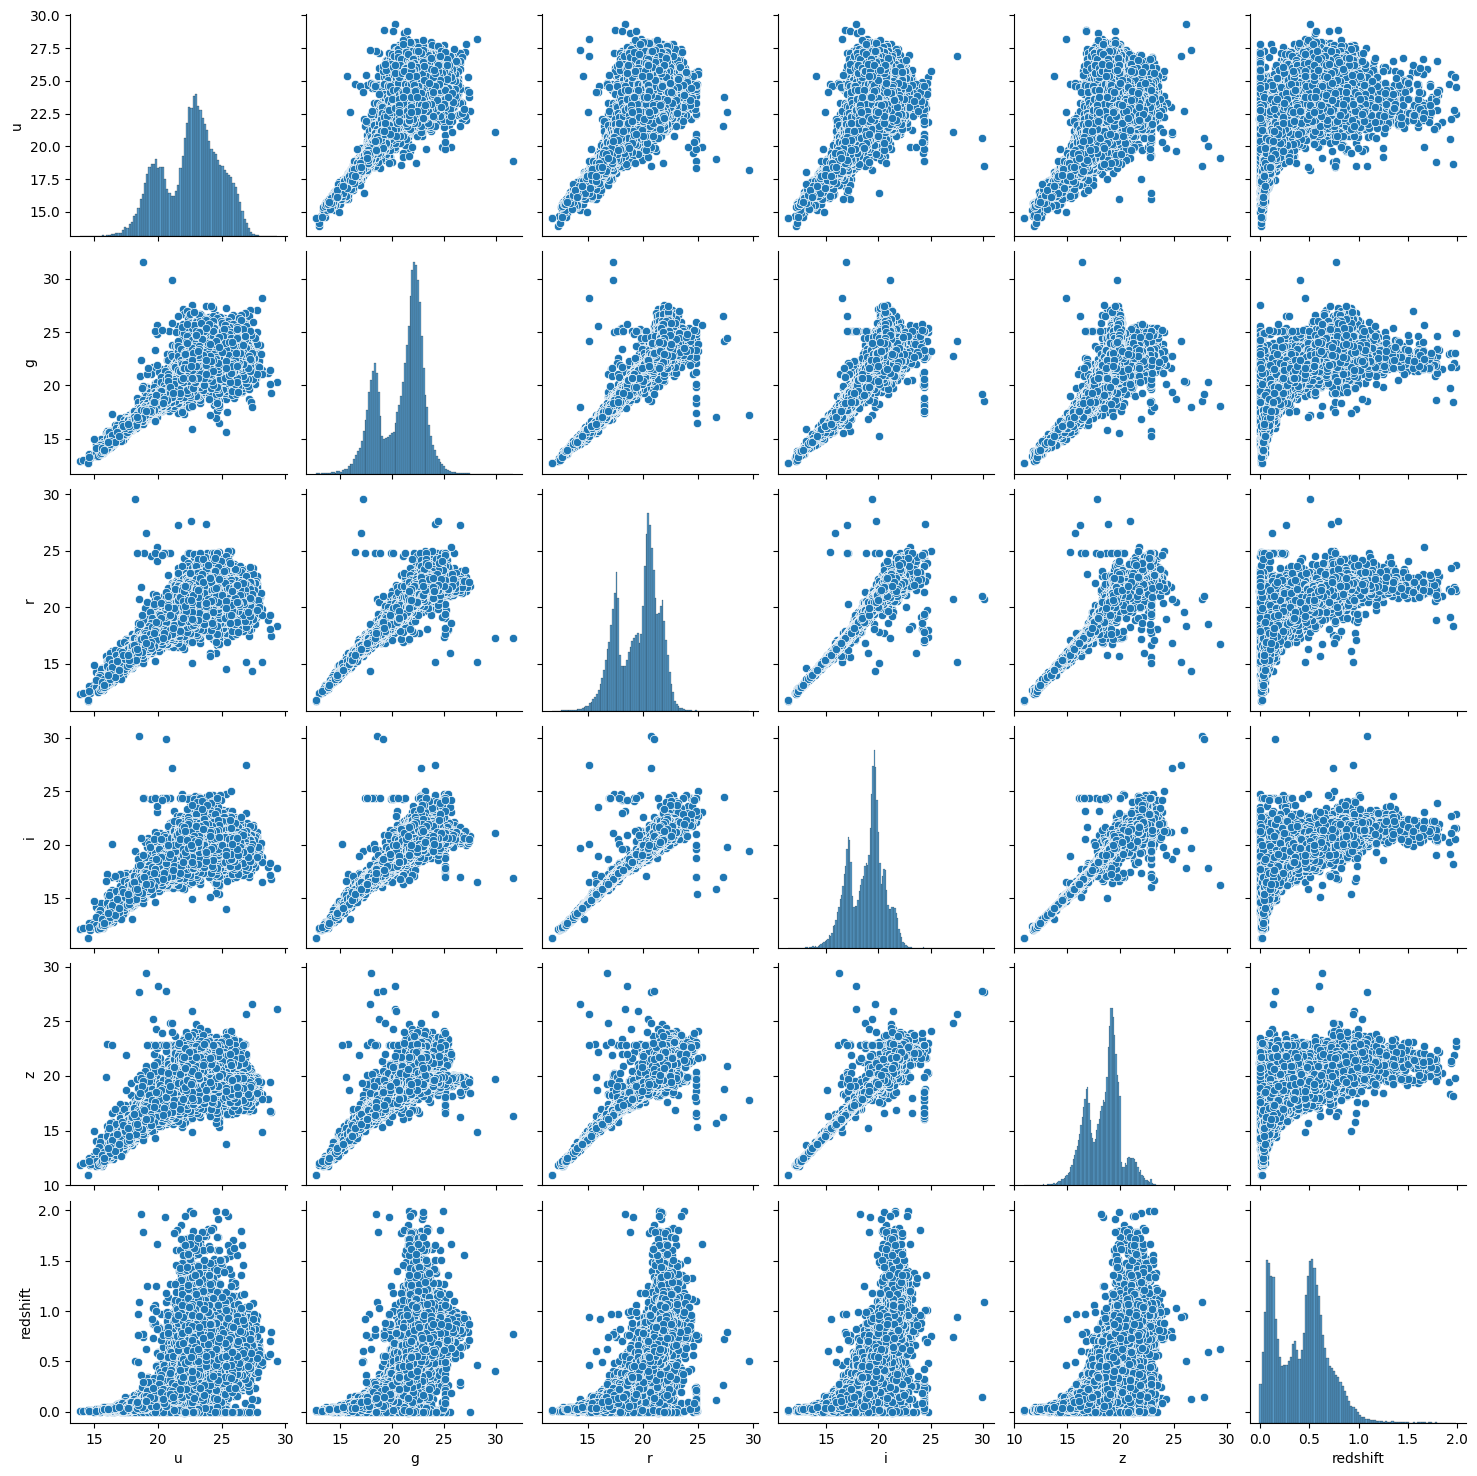

In [ ]:
# Pairplot to show what the data looks like
import seaborn as sns

sns.pairplot(input_spectra.drop(['alpha', 'delta'], axis=1))
plt.show()

#### SDSS Images

Below, we will perform an example API call to the SDSS website in order to demonstrate the differences between the three classes. For the code used to download all 10,000 images, please refer to the following link:

[SDSS_API_Call.ipynb](https://colab.research.google.com/drive/1QxUY_XqzVzUEJ4c1X7oJaaje26g12h9v?usp=sharing)

In [ ]:
import requests

# API Call function: inputs coordinates, image dimensions and scale; outputs image of stellar object
def get_color_image(ra, dec):
    url = "http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
    params = {
        "ra": ra,
        "dec": dec,
        "scale": 0.1,
        "height": 64,
        "width": 64,
        "opt": ''
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raise an exception for 4xx and 5xx status codes
        return response.content  # Return the binary image data
    except requests.exceptions.RequestException as e:
        print(f"Error fetching image: {e}")
        return None

In [ ]:
# API Call function retrieves image binary, which we convert to RGB matrix with this function
def binary_to_rgb(image_binary):

    # Convert binary image data to PIL Image object
    pil_image = Image.open(io.BytesIO(image_binary))

    # Convert PIL Image to numpy array
    rgb_array = np.array(pil_image)

    # If the image is grayscale, convert it to RGB by repeating the grayscale values along the third axis
    if len(rgb_array.shape) == 2:
        rgb_array = np.stack((rgb_array,) * 3, axis=-1)

    return rgb_array

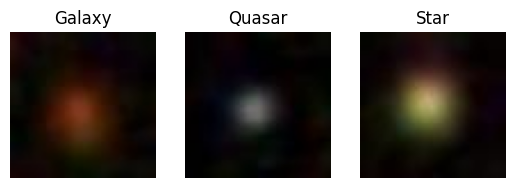

In [ ]:
# Some alpha, delta values pasted from spectra Excel sheet for demonstration purposes
ra = [np.array(galaxies['alpha'])[6], np.array(qsos['alpha'])[1], np.array(stars['alpha'])[0]]
dec = [np.array(galaxies['delta'])[6], np.array(qsos['delta'])[1], np.array(stars['delta'])[0]]
classes = ['Galaxy', 'Quasar', 'Star']
# Run both functions to show example images
plt.figure()
for i in range(3):
    ra_item = ra[i]
    dec_item = dec[i]
    test_image_binary = get_color_image(ra=ra_item, dec=dec_item)
    test_image = binary_to_rgb(test_image_binary)
    plt.subplot(1, 3, i+1)
    plt.imshow(test_image)
    plt.axis('off')
    plt.title(classes[i])

#### Scaling and Portioning

In [ ]:
# Mount to Google Drive so images in Drive can be accessed by Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.transforms as transforms
from skimage.metrics import structural_similarity as ssim

# Define transform function to convert image to tensor of proper dimensions
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
N = 10000 # Use 10,000 images
indices = np.array(input_spectra.index)

# For each image, retrieve RGB matrix from Google Drive
for i in indices[:N]:

    # Open the JPEG file
    image = Image.open("/content/drive/MyDrive/star_images/image" + str(i) + ".jpg")
    # Convert the image to RGB if it's not already in RGB mode
    image = image.convert("RGB")
    # Convert the image to a numpy array
    rgb_matrix = np.array(transform(np.array(image)))
    # Append matrix to image list
    output_images.append(rgb_matrix)

In [ ]:
# Cut off spectra we are not using
input_spectra = input_spectra[:N]

# Check dimensions of input spectra and output images
print(input_spectra.shape, np.array(output_images).shape)

(10000, 8) (10000, 3, 64, 64)


In [ ]:
# Convert numpy arrays to PyTorch tensors
inputs_tensor = torch.tensor(np.array(input_spectra), dtype=torch.float32)
inputs_tensor = torch.nn.functional.normalize(inputs_tensor.unsqueeze(-1)) # Usqueeze to match 1D convolutional format

outputs_tensor = torch.tensor(np.array(output_images), dtype=torch.float32)

In [ ]:
# Portion input spectra and output images 80 - 10 - 10 for train, validation, and test
val_index = int(0.8 * N)
test_index = int(0.9 * N)

train_inputs = inputs_tensor[:val_index]
val_inputs = inputs_tensor[val_index:test_index]
test_inputs = inputs_tensor[test_index:]

train_outputs = outputs_tensor[:val_index]
val_outputs = outputs_tensor[val_index:test_index]
test_outputs = outputs_tensor[test_index:]

# Verify dimensions of each dataset
print("Dimensions of train data: ", train_inputs.shape, train_outputs.shape)
print("Dimensions of validation data: ", val_inputs.shape, val_outputs.shape)
print("Dimensions of test data: ", test_inputs.shape, test_outputs.shape)

Dimensions of train data:  torch.Size([8000, 8, 1]) torch.Size([8000, 3, 64, 64])
Dimensions of validation data:  torch.Size([1000, 8, 1]) torch.Size([1000, 3, 64, 64])
Dimensions of test data:  torch.Size([1000, 8, 1]) torch.Size([1000, 3, 64, 64])


### **Define Model**

In [ ]:
# Create a custom PyTorch Dataset
class MyDataset(Dataset):
    def __init__(self, spectra, images):
        self.spectra = spectra
        self.images = images

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.images[idx]

# Create DataLoader for batch processing
train_dataset = MyDataset(train_inputs, train_outputs)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

In [ ]:
# Number of features in the spectral data
num_features = 8
# Number of channels in the output image (3 for RGB, 64x64 image size)
num_channels = 64 * 64

# Define the autoencoder CNN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder part of the autoencoder: output channels scale 2X at each convolution, ReLU activation and Max Pooling between each layer
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1), # 1st Conv layer: input to 32 channels
            nn.ReLU(), # Activation function
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1), # Downsampling by max pooling
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 2nd Conv layer: 32 to 64 channels
            nn.ReLU(), # Activation function
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1), # Downsampling by max pooling
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 3rd Conv layer: 64 to 128 channels
            nn.ReLU(), # Activation function
            nn.MaxPool1d(kernel_size=2, stride=2, padding=1) # Downsampling by max pooling
        )

        # Fully connected bottleneck layer of size 256, dense layer to represent the compressed data
        self.bottleneck = nn.Sequential(
            nn.Flatten(), # Flatten for FC layer
            nn.Linear(128, 256), # Fully connected layer of size 256
            nn.ReLU(), # Activation function
            nn.Linear(256, 128), # Fully connected layer expanding back to original size
            nn.ReLU(), # Activation function
            nn.Unflatten(1, (128, -1)) # Unflatten for decoder, -1 dim to infer size
        )

        # Decoder part of autoencooder: transposed convolutional layers to reconstruct output data
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=3, padding=1), # 1st Deconv layer: 128 to 64 channels
            nn.ReLU(), # Activation function
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, padding=1), # 2nd Deconv layer: 64 to 32 channels
            nn.ReLU(), # Activation function
            nn.ConvTranspose1d(in_channels=32, out_channels=num_channels, kernel_size=3, padding=0), # 3rd Deconv layer: 32 to output channels
            nn.Sigmoid() # Output layer with sigmoid activation to ensure output values are in range [0, 1]
        )

    def forward(self, x):
        # Pass input through encoder, bottleneck, and decoder
        x = self.encoder(x)
        x = self.bottleneck(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder model
autoencoder = Autoencoder()

In [ ]:
autoencoder

Autoencoder(
  (encoder): Sequential(
    (0): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Unflatten(dim=1, unflattened_size=(128, -1))
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(64, 32, kernel_size=(3

### **Define Hyperparameters**

In [ ]:
num_epochs = 20
learning_rate = 0.001
criterion = nn.MSELoss() # MSE loss is useful for computing loss in images
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate) # Use Adam as optimizer

### **Identify Tracked Values**

In [ ]:
# Initialize Training Loss and Validation Accuracy list
train_loss_list = []
val_accuracy_list = []

### **Train Model**

In [ ]:
# Train the autoencoder
for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize running loss for the epoch

    for spectra, images in train_dataloader:
        optimizer.zero_grad()  # Zero the gradients for the optimizer
        outputs = autoencoder(spectra)  # Forward pass: compute the reconstructed images

        # Reshape outputs to match the shape of images
        outputs = outputs.reshape(10, 3, 64, 64)

        loss = criterion(outputs, images)  # Compute the loss between the outputs and the actual images
        loss.backward()  # Backward pass: compute the gradient of the loss
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()  # Accumulate the running loss
        train_loss_list.append(loss.item())  # Append the loss to the training loss list

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}")

    # Evaluate the model on the validation set
    with torch.no_grad():
        # Generate validation outputs
        generated_val_outputs = autoencoder(nn.functional.normalize(val_inputs)).detach()

        # Reshape the validation outputs to match the shape of images
        generated_val_outputs = generated_val_outputs.reshape(len(val_outputs), 3, 64, 64)

        # Permute the dimensions to match the expected format for SSIM calculation
        generated_val_outputs = generated_val_outputs.permute(0, 2, 3, 1)

        ssim_arr = []  # Initialize list to store SSIM values

        for index, generated_output in enumerate(generated_val_outputs):
            a = generated_output  # Generated output image
            b = val_outputs[index].permute(1, 2, 0)  # Corresponding validation image

            # Compute the SSIM between the generated image and the validation image
            ssim_value = ssim(np.array(a), np.array(b), channel_axis=2)

            ssim_arr.append(ssim_value)  # Append the SSIM value to the list

        val_accuracy_list.append(np.mean(ssim_arr))  # Append the mean SSIM value to the validation accuracy list

Epoch [1/20], Loss: 0.005713668136158958
Epoch [2/20], Loss: 0.005624523484875681
Epoch [3/20], Loss: 0.005741321937966859
Epoch [4/20], Loss: 0.005768383748072665
Epoch [5/20], Loss: 0.005644682278434629
Epoch [6/20], Loss: 0.00561356698119198
Epoch [7/20], Loss: 0.00568115544396278
Epoch [8/20], Loss: 0.0058044598628475795
Epoch [9/20], Loss: 0.005535271718908916
Epoch [10/20], Loss: 0.00558564859420585
Epoch [11/20], Loss: 0.005553312204719987
Epoch [12/20], Loss: 0.005573573207293521
Epoch [13/20], Loss: 0.005654867227858631
Epoch [14/20], Loss: 0.005719459021784132
Epoch [15/20], Loss: 0.005455893484249828
Epoch [16/20], Loss: 0.005478691436437657
Epoch [17/20], Loss: 0.005535875093264622
Epoch [18/20], Loss: 0.005542858442349825
Epoch [19/20], Loss: 0.005402121239967528
Epoch [20/20], Loss: 0.00552893516542099


### **Visualize and Evaluate Model**

Text(0.5, 0, 'Epochs')

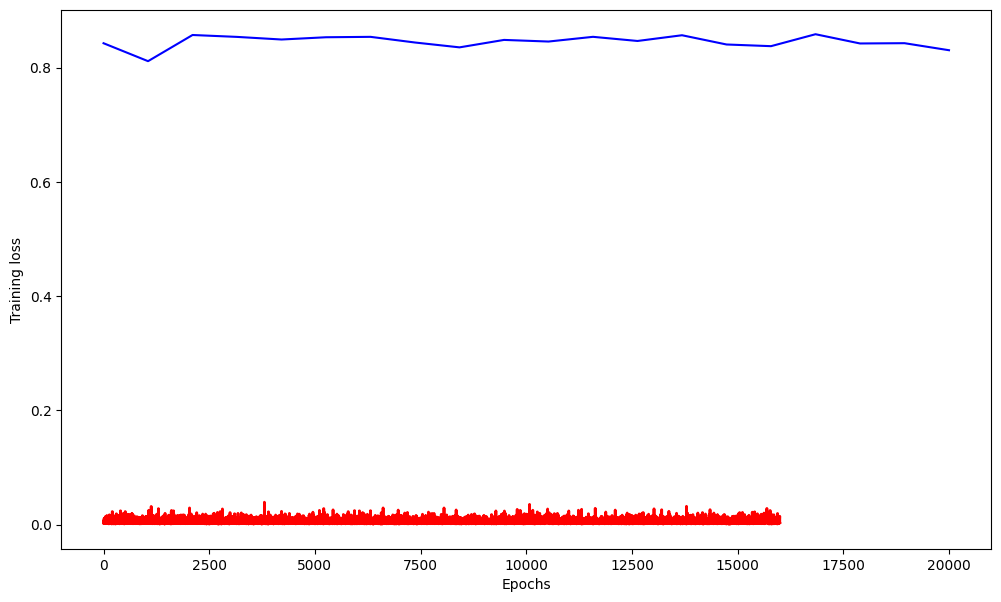

In [ ]:
# Plots the training loss and validation accuracy
plt.figure(figsize = (12, 7))
plt.plot(np.linspace(0, 20000, 20), val_accuracy_list, color = 'blue')
plt.plot(train_loss_list, linewidth = 2, color = 'red')
plt.ylabel("Training loss")
plt.xlabel("Epochs")

In [ ]:
# Generate images from test spectra
generated_test_images = autoencoder(nn.functional.normalize(test_inputs)).detach()
generated_test_images = generated_test_images.reshape(1000, 3, 64, 64)

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Define function for plotting and comparing two images
def compare_images(image1, image2):
    s = ssim(image1, image2, channel_axis=2)
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.axis('off')
    plt.title('Generated Image ' + 'SSIM: %.2f' % (s))
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    plt.title('Actual SDSS Image')
    plt.axis('off')

    return s


In [ ]:
ssim_list = [] # Initialize list for collecting ssim values
for i in range(1000):
    a = generated_test_images[i].permute(1, 2, 0) # Image A is the generated images from autoncoder
    a = np.array(a)

    b = np.array(test_outputs.permute(0, 2, 3, 1))[i] # Image B is the actual image from SDSS dataset
    ssim_list.append(ssim(a, b, channel_axis=2))

print('Accuracy: ', np.mean(ssim_list)) # Accuracy is mean of all SSIM values from testing data

sort_ssim_list = np.sort(ssim_list)

Accuracy:  0.8332025


The three worst predictions:


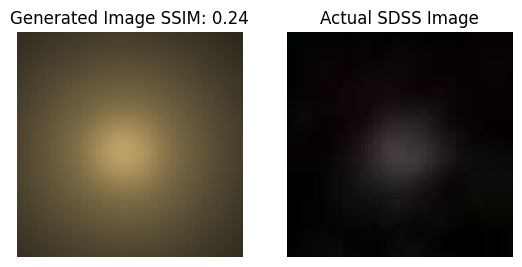

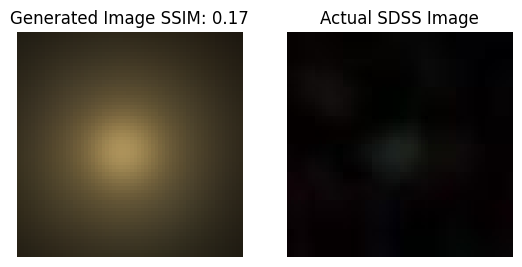

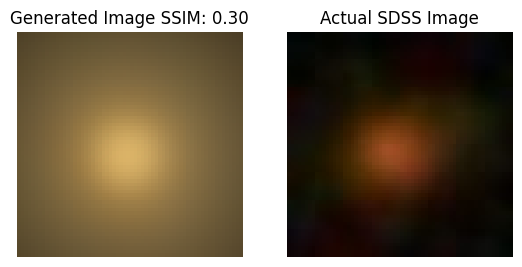

In [ ]:
# Visualize three worst predictions
print("The three worst predictions:")
for index in range(1000):
    for n in range(3):
        if ssim_list[index] == sort_ssim_list[n]:
            worst_index = index
            a = np.array(generated_test_images[worst_index].permute(1, 2, 0))
            b = np.array(test_outputs.permute(0, 2, 3, 1))[index]
            compare_images(a, b)
            break

The three best predictions:


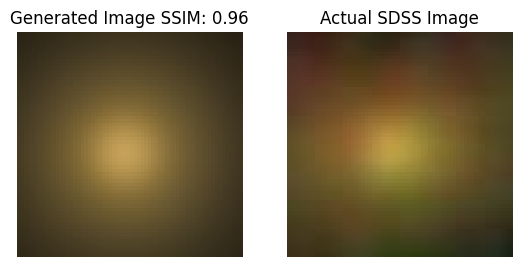

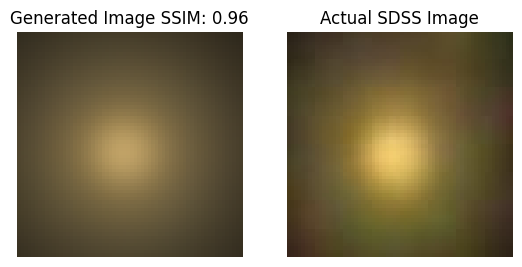

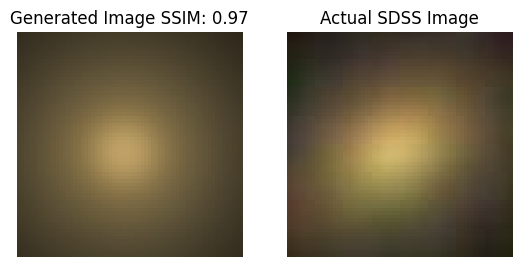

In [ ]:
# Visualize three best predictions
print("The three best predictions:")
for index in range(1000):
    for n in range(3):
        if ssim_list[index] == sort_ssim_list[-(n+1)]:
            best_index = index
            a = np.array(generated_test_images[best_index].permute(1, 2, 0))
            b = np.array(test_outputs.permute(0, 2, 3, 1))[index]
            compare_images(a, b)
            break

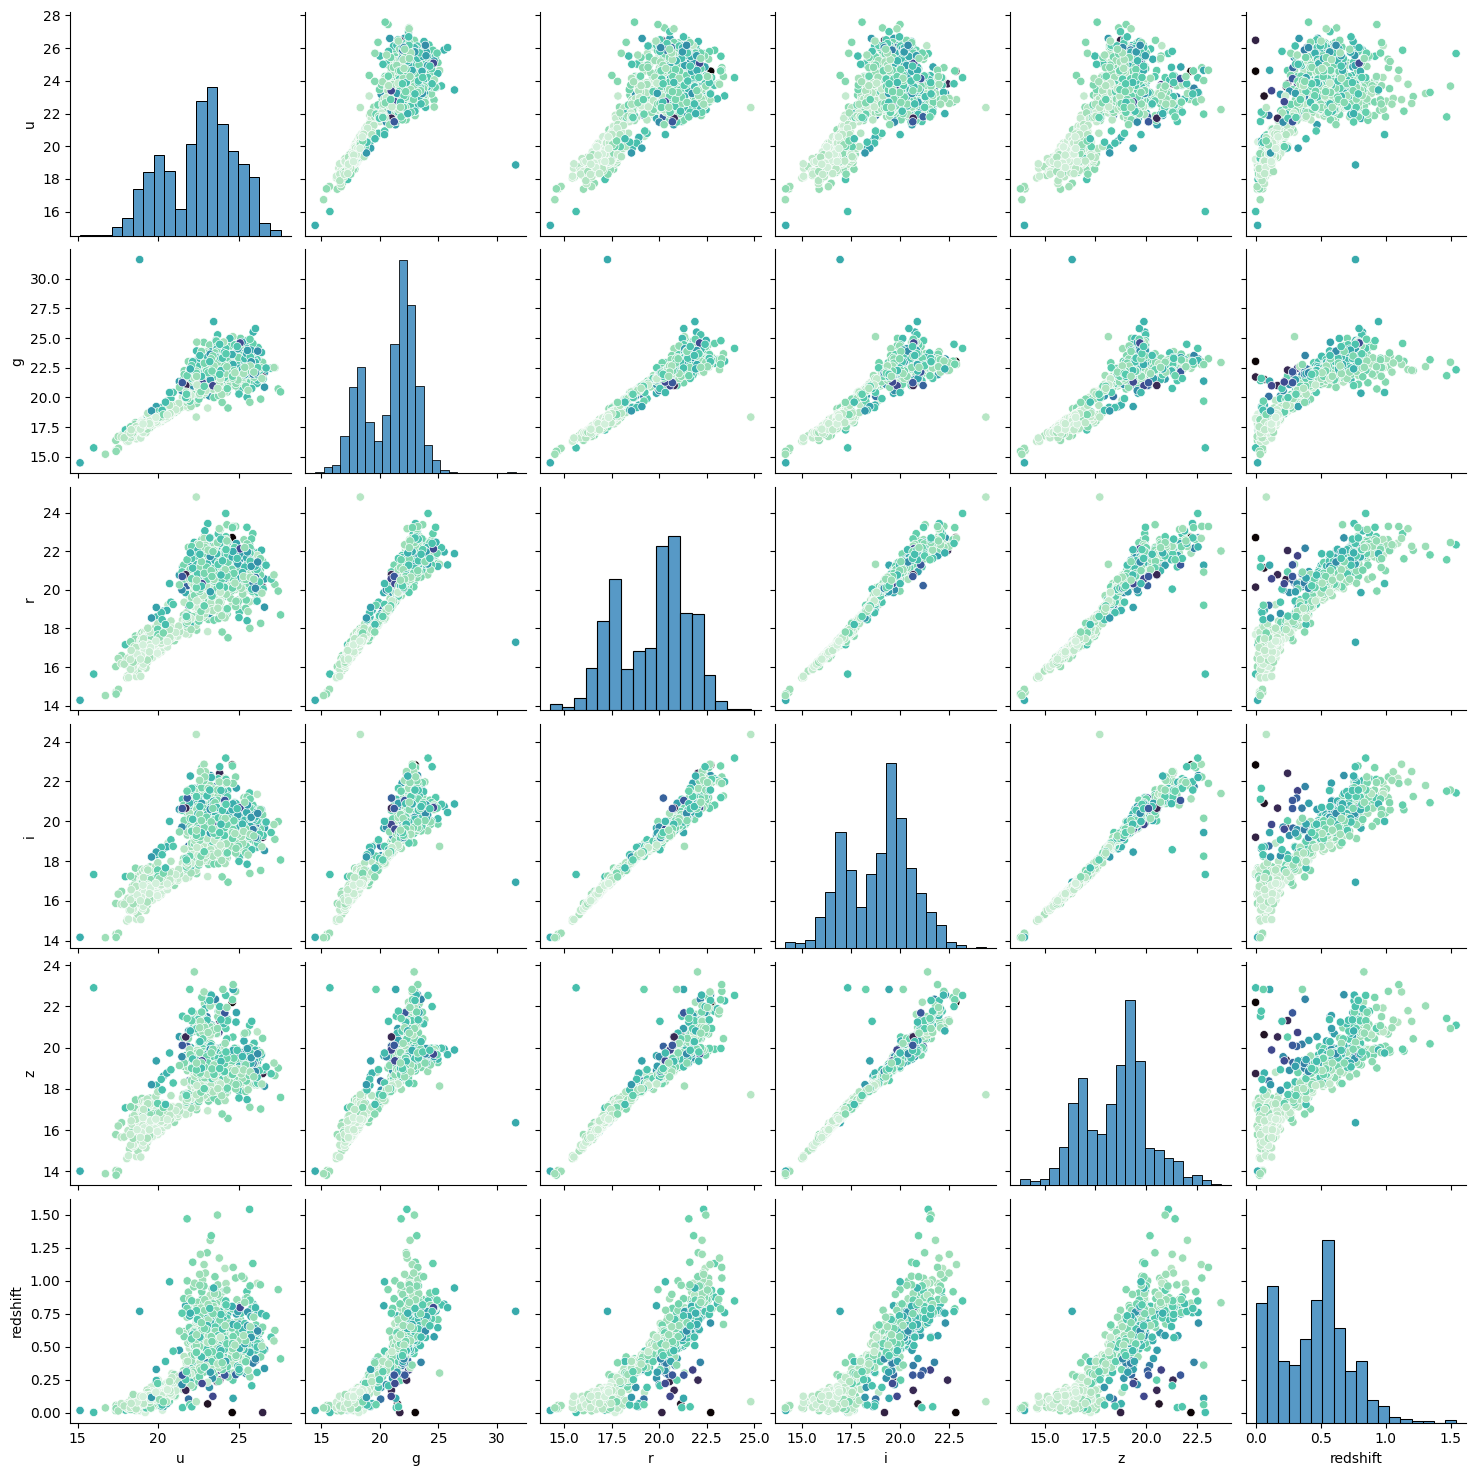

In [ ]:
# Visualize test spectra with SSIM data for shading on plot
    # Notice that the worse the NN predicts, the more of an outlier the object is in redshift

sns.pairplot(input_spectra[-1000:].drop(['alpha', 'delta'], axis=1), plot_kws=dict(
        hue=np.array(ssim_list),
        palette="mako", legend = True))
plt.show()